In [46]:
# ------------------------------------------
# Script: 7 (Pathogen_support.ipynb)
# ------------------------------------------
# Author: Pratyay Sengupta
# ------------------------------------------

In [66]:
# Import required libraries
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.colors as pc
import plotly.graph_objects as go
import random
import seaborn as sns
from scipy.stats import kruskal, mannwhitneyu, fisher_exact
from statsmodels.stats.multitest import multipletests

# Set data directories
input_dir = '/mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Output_data/'
figure_dir = '/mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Figures/'

In [47]:
# -----------------------------
# Load pathogen data
# -----------------------------

# Load pathogen biosafety level data
df_pathogen = pd.read_csv(os.path.join(input_dir, 'gcPathogen_20241019.txt'), sep='|')

# Load binary presence/absence data of microbial taxa across environments
df_taxa = pd.read_csv(os.path.join(input_dir, '1_taxa_binary.csv'), index_col=0)

# Create a mapping from pathogen names to biosafety levels
biosafety_map = df_pathogen.set_index('Pathogen name')['Biosafety level'].to_dict()

# Annotate taxa data with pathogen presence and biosafety level
df_taxa['Present'] = df_taxa.index.map(lambda x: 'Yes' if x in biosafety_map else 'No')
df_taxa['Biosafety level'] = df_taxa.index.map(biosafety_map).fillna('NA')

# Convert 'NA' biosafety levels to 'Non-pathogen'
df_taxa['Biosafety level'] = df_taxa.apply(
    lambda row: 'Non-pathogen' if row['Present'] == 'No' else row['Biosafety level'], axis=1
)

# Normalize organism names to standard format
df_taxa.index = (
    df_taxa.index.str.replace(" ", "_")
                  .str.replace('Kocuria_sp._UCD-OTCP', 'Kocuria_sp.')
                  .str.replace('Roseomonas_sp._B5', 'Roseomonas_sp.')
                  .str.replace('Dermacoccus_sp._Ellin185', 'Dermacoccus_sp.')
)

# Save annotated taxa data
df_taxa.to_csv(os.path.join(input_dir, '4_taxa_binary_pathogen.tsv'), sep='\t')

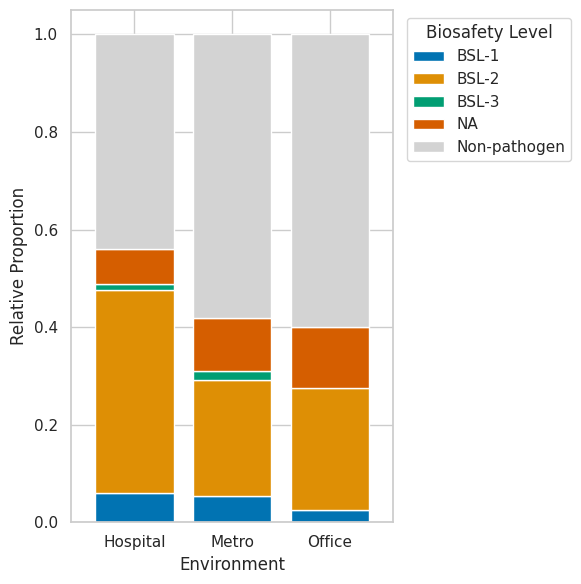

In [53]:
# -------------------------------------------
# Plot relative distribution by biosafety level
# -------------------------------------------

# Set seaborn style
sns.set(style='whitegrid')

# Define environments to compare
environments = ['Hospital', 'Metro', 'Office']
biosafety_levels = sorted(df_taxa['Biosafety level'].unique())

# Calculate relative proportions for stacked bar plot
proportions = pd.DataFrame(index=biosafety_levels)
for env in environments:
    env_counts = df_taxa.groupby('Biosafety level')[env].sum()
    env_proportions = env_counts / env_counts.sum()
    proportions[env] = env_proportions
proportions = proportions.fillna(0)

# Define color palette
palette = sns.color_palette("colorblind", n_colors=len(proportions))
color_map = {
    level: ('lightgrey' if level == 'Non-pathogen' else palette[i])
    for i, level in enumerate(biosafety_levels)
}
colors = [color_map[level] for level in biosafety_levels]

# Plot
fig, ax = plt.subplots(figsize=(6, 6))
proportions.T.plot(kind='bar', stacked=True, color=colors, ax=ax, width=0.8)
ax.set_xlabel('Environment', fontsize=12)
ax.set_ylabel('Relative Proportion', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.legend(title='Biosafety Level', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(figure_dir, 'Figure_6A.svg'), format='svg', dpi=500)
plt.show()


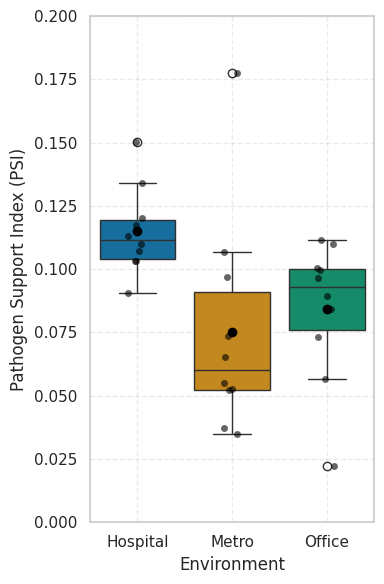

In [59]:
# -------------------------------------------
# Calculate Pathogen Support Index (PSI)
# -------------------------------------------

# Directory containing Smetana output files
smetana_dir = "/mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Modeling/Community_9_detailed_segregated/Smetana_output/"
smetana_files = glob.glob(os.path.join(smetana_dir, "result_*.tsv_detailed.tsv"))

# Initialize PSI results dictionary
psi_scores = {env: [] for env in environments}

# Iterate over all Smetana result files
for file in smetana_files:
    df = pd.read_csv(file, sep="\t")
    df["receiver"] = df["receiver"].str.strip()
    df["donor"] = df["donor"].str.strip()

    total_smetana = df["smetana"].sum()
    pathogen_receivers = [r for r in df["receiver"].unique()
                          if r in df_taxa.index and df_taxa.loc[r, "Present"] == "Yes"]
    smetana_pathogen = df[df["receiver"].isin(pathogen_receivers)]["smetana"].sum()

    all_species = pd.concat([df["receiver"], df["donor"]]).unique()
    community_size = len(set(all_species))
    pathogen_species = [sp for sp in all_species if sp in df_taxa.index and df_taxa.loc[sp, "Present"] == "Yes"]
    num_pathogens = len(set(pathogen_species))

    psi = ((smetana_pathogen / total_smetana) / num_pathogens) if (total_smetana > 0 and num_pathogens > 0) else 0

    # Assign to appropriate environment
    filename = os.path.basename(file)
    for env in environments:
        if env in filename:
            psi_scores[env].append(psi)

# Convert PSI results to DataFrame
df_psi = pd.DataFrame([
    {"Environment": env, "PSI": score}
    for env, values in psi_scores.items()
    for score in values
])
df_psi["Environment"] = pd.Categorical(df_psi["Environment"], categories=environments, ordered=True)

# Plot PSI distribution
plt.figure(figsize=(4, 6))
sns.boxplot(x="Environment", y="PSI", hue="Environment", data=psi_df, palette="colorblind", showmeans=True,
            meanprops={"marker": "o", "markerfacecolor": "black", "markeredgecolor": "black"},
            legend=False)
sns.stripplot(x="Environment", y="PSI", data=psi_df, color='black', jitter=True, alpha=0.6)
plt.ylim(0, 0.20)
plt.ylabel("Pathogen Support Index (PSI)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig(os.path.join(figure_dir, 'Figure_6B.svg'), format='svg', dpi=500)
plt.show()


In [60]:
# -------------------------------------------
# Statistical testing: PSI comparisons
# -------------------------------------------

# Group PSI values by environment
psi_groups = df_psi.groupby('Environment', observed=True)['PSI'].apply(list)

# Kruskal-Wallis test
stat, p_kw = kruskal(*psi_groups)
print(f"Kruskal-Wallis test: H = {stat:.4f}, p = {p_kw:.4e}")

# Pairwise Mann-Whitney U tests
results = []
envs = psi_groups.index.tolist()
for env1, env2 in itertools.combinations(envs, 2):
    data1, data2 = psi_groups[env1], psi_groups[env2]
    try:
        u_stat, p_val = mannwhitneyu(data1, data2)
    except ValueError:
        u_stat, p_val = float('nan'), float('nan')
    results.append({
        "Group1": env1, "Group2": env2,
        "U_statistic": u_stat, "Raw_p": p_val
    })

# Multiple testing correction
pvals = [r["Raw_p"] for r in results]
reject, pvals_adj, _, _ = multipletests(pvals, method="fdr_bh")
for i, res in enumerate(results):
    res["Corrected_p"] = pvals_adj[i]
    res["Significant"] = "Yes" if reject[i] else "No"

df_stats = pd.DataFrame(results)
print(df_stats)

Kruskal-Wallis test: H = 10.9342, p = 4.2235e-03
     Group1  Group2  U_statistic     Raw_p  Corrected_p Significant
0  Hospital   Metro         86.0  0.007285     0.010927         Yes
1  Hospital  Office         87.0  0.005795     0.010927         Yes
2     Metro  Office         34.0  0.241322     0.241322          No


In [69]:
# -------------------------------------------
# Sankey Flow: Donor ➝ Environment ➝ Compound ➝ Pathogen Status
# -------------------------------------------

# Load metabolite mapping and HMDB subclass annotations
modeling_dir = '/mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Modeling/'
df_met_names = pd.read_csv(os.path.join(modeling_dir, 'bigg_models_metabolites.txt'), sep="\t")
df_hmdb = pd.read_csv(os.path.join(modeling_dir, 'HMDB_subclass.tsv'), sep="\t")

# Create dictionaries
compound_name_map = dict(zip(df_met_names['universal_bigg_id'], df_met_names['name']))
hmdb_class_map = dict(zip(df_hmdb['Compound'], df_hmdb['HMDB_Subclass']))
pathogen_status_map = df_taxa['Present'].map({"Yes": "Pathogen", "No": "Non-pathogen"}).to_dict()

# Process compound flow data
flow_records = []
for fname in os.listdir(smetana_dir):
    if not fname.endswith(".tsv"):
        continue
    env = fname.split("_")[1]
    df = pd.read_csv(os.path.join(smetana_dir, fname), sep="\t")
    for _, row in df.iterrows():
        donor = row["donor"]
        receiver = row["receiver"]
        compound_id = pd.Series([row["compound"]]).str.replace(r'^M_(.*)_e$', r'\1', regex=True).iloc[0]
        compound_name = compound_name_map.get(compound_id, compound_id)
        subclass = hmdb_class_map.get(compound_name, compound_name)
        status = pathogen_status_map.get(receiver, "Unknown")
        if status != "Unknown":
            flow_records.append((donor, env, subclass, status))

# Convert to DataFrame
df_flow = pd.DataFrame(flow_records, columns=["Donor", "Environment", "HMDB_Subclass", "Pathogen_Status"])

# Aggregate flows for each link layer
# Aggregate flow counts for each transition
df_de = df_flow.groupby(["Donor", "Environment"]).size().reset_index(name="count")
df_ec = df_flow.groupby(["Environment", "HMDB_Subclass"]).size().reset_index(name="count")
df_cp = df_flow.groupby(["HMDB_Subclass", "Pathogen_Status"]).size().reset_index(name="count")

# Unique node list and indexing
nodes = pd.unique(df_flow[["Donor", "Environment", "HMDB_Subclass", "Pathogen_Status"]].values.ravel()).tolist()
node_index = {name: i for i, name in enumerate(nodes)}

# Build links
def make_links(df, source_col, target_col):
    return [
        dict(source=node_index[row[source_col]],
             target=node_index[row[target_col]],
             value=row["count"])
        for _, row in df.iterrows()
    ]

links = (
    make_links(df_de, "Donor", "Environment") +
    make_links(df_ec, "Environment", "HMDB_Subclass") +
    make_links(df_cp, "HMDB_Subclass", "Pathogen_Status")
)

# Extract source/target/value for Plotly
sources = [link["source"] for link in links]
targets = [link["target"] for link in links]
values = [link["value"] for link in links]

# -------------------------------
# Plot Sankey Diagram
# -------------------------------

# Assign groups for nodes by their category
node_groups = {}
for name in nodes:
    if name in df_flow["Donor"].values:
        node_groups[name] = "Donor"
    elif name in df_flow["Environment"].values:
        node_groups[name] = "Environment"
    elif name in df_flow["HMDB_Subclass"].values:
        node_groups[name] = "HMDB_Subclass"
    elif name in df_flow["Pathogen_Status"].values:
        node_groups[name] = "Pathogen_Status"
    else:
        node_groups[name] = "Unknown"

# Define custom color palette for each group
group_colors = {
    "Donor": pc.qualitative.Dark24[0:8],
    "Environment": pc.qualitative.Set2[0:8],
    "HMDB_Subclass": pc.qualitative.Pastel1[0:8],
    "Pathogen_Status": pc.qualitative.Set3[0:8]
}

# Assign a color to each node based on its group
node_colors = []
color_indices = {"Donor": 0, "Environment": 0, "HMDB_Subclass": 0, "Pathogen_Status": 0}

for name in nodes:
    group = node_groups[name]
    if group in group_colors:
        color_list = group_colors[group]
        color = color_list[color_indices[group] % len(color_list)]
        color_indices[group] += 1
    else:
        color = "grey"
    node_colors.append(color)

# Plot Sankey diagram with node color mapping
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=nodes,
        color=node_colors
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values
    )
)])

fig.update_layout(
    title_text="Donor → Environment → HMDB Subclass → Pathogen Status",
    font_size=12,
    width=1200,
    height=1000
)

fig.show()

# Save the figure
output_path = "/mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Figures/Supplementary_Figure_5.svg"
fig.write_image(output_path)

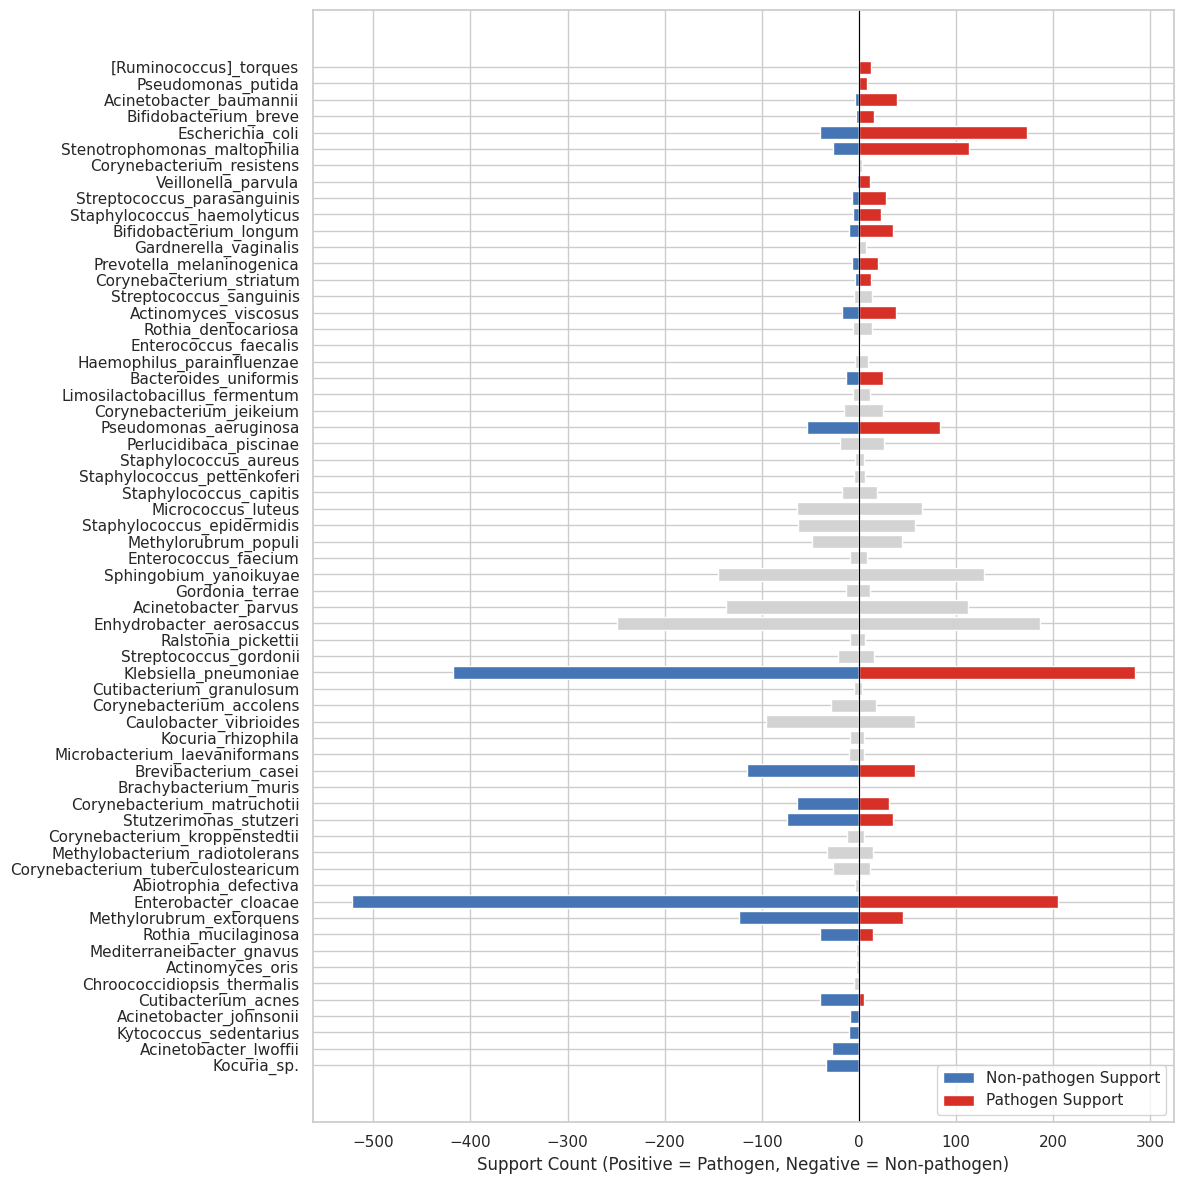

In [74]:
# -------------------------------
# Donor-Level Enrichment Analysis
# -------------------------------

donor_counts = flow_df.groupby(["Donor", "Pathogen_Status"]).size().unstack(fill_value=0)
donor_counts = donor_counts.reindex(columns=["Pathogen", "Non-pathogen"], fill_value=0)

total_pathogen = donor_counts["Pathogen"].sum()
total_nonpath = donor_counts["Non-pathogen"].sum()

donor_results = []

for donor, row in donor_counts.iterrows():
    a, b = row["Pathogen"], row["Non-pathogen"]
    c = total_pathogen - a
    d = total_nonpath - b
    
    odds, p = fisher_exact([[a, b], [c, d]])
    
    donor_results.append({
        "Donor": donor,
        "Pathogen_Count": a,
        "Non_pathogen_Count": b,
        "Odds_Ratio": odds,
        "P_Value": p
    })

donor_df = pd.DataFrame(donor_results)

# Adjust p-values
donor_df["P_Value_adj"] = multipletests(donor_df["P_Value"], method="fdr_bh")[1]
donor_df["Significant"] = donor_df["P_Value_adj"] < 0.05
donor_df["log2FC"] = np.log2((donor_df["Pathogen_Count"] + 1) / (donor_df["Non_pathogen_Count"] + 1))

# Sort for plotting
donor_df = donor_df.sort_values("log2FC")

# --- Plot ---

plt.figure(figsize=(12, 12))
sns.set(style="whitegrid")

y_pos = np.arange(len(donor_df))
colors_path = ["#D73027" if sig else "lightgrey" for sig in donor_df["Significant"]]
colors_nonpath = ["#4575B4" if sig else "lightgrey" for sig in donor_df["Significant"]]

plt.barh(y_pos, -donor_df["Non_pathogen_Count"], color=colors_nonpath, label="Non-pathogen Support")
plt.barh(y_pos, donor_df["Pathogen_Count"], color=colors_path, label="Pathogen Support")

plt.yticks(y_pos, donor_df["Donor"])
plt.axvline(0, color="black", linewidth=0.8)
plt.xlabel("Support Count (Positive = Pathogen, Negative = Non-pathogen)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(os.path.join(figure_dir, 'Figure_6C.svg'), format='svg', dpi=500)
plt.show()


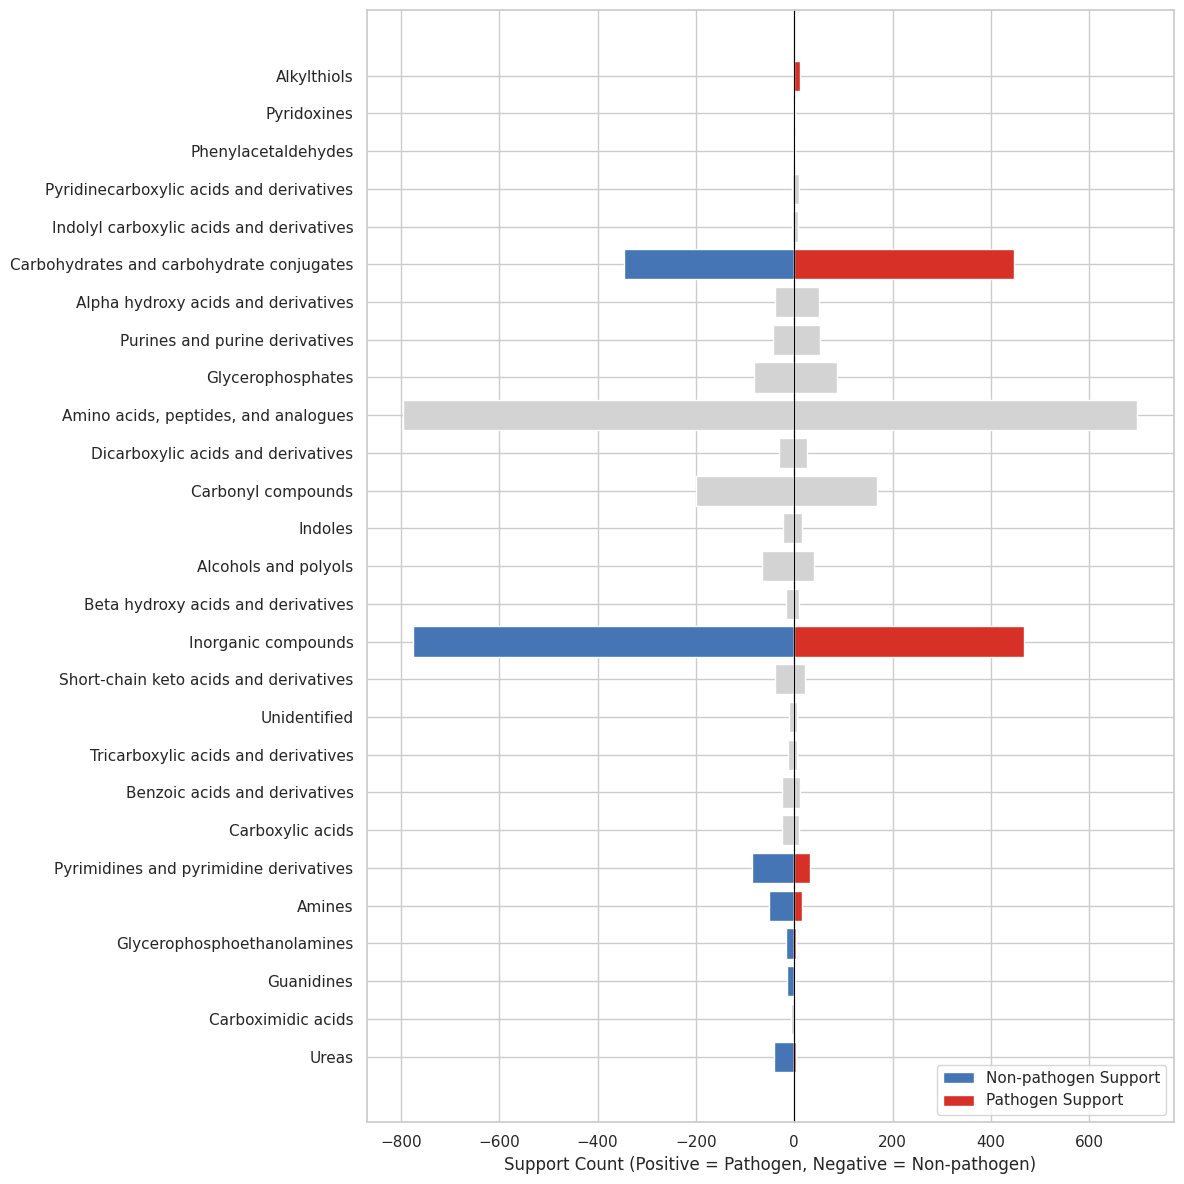

In [75]:
# -------------------------------
# Compound-Level Enrichment Analysis
# -------------------------------

# Count compound transfers to each Pathogen_Status
compound_counts = flow_df.groupby(["HMDB_Subclass", "Pathogen_Status"]).size().unstack(fill_value=0)

# Ensure both groups are represented
compound_counts = compound_counts.reindex(columns=["Pathogen", "Non-pathogen"], fill_value=0)

# Total counts for both groups
total_pathogen = compound_counts["Pathogen"].sum()
total_nonpath = compound_counts["Non-pathogen"].sum()

compound_results = []

for compound, row in compound_counts.iterrows():
    a = row["Pathogen"]
    b = row["Non-pathogen"]
    c = total_pathogen - a
    d = total_nonpath - b
    
    odds, p = fisher_exact([[a, b], [c, d]])
    
    compound_results.append({
        "Compound": compound,
        "Pathogen_Count": a,
        "Non_pathogen_Count": b,
        "Odds_Ratio": odds,
        "P_Value": p
    })

compound_df = pd.DataFrame(compound_results)

# Multiple testing correction
compound_df["P_Value_adj"] = multipletests(compound_df["P_Value"], method="fdr_bh")[1]
compound_df["Significant"] = compound_df["P_Value_adj"] < 0.05

# Log2 fold-change
compound_df["log2FC"] = np.log2((compound_df["Pathogen_Count"] + 1) / (compound_df["Non_pathogen_Count"] + 1))

# Sort for plotting
compound_df = compound_df.sort_values("log2FC")

# --- Plot ---

plt.figure(figsize=(12, 12))
sns.set(style="whitegrid")

y_pos = np.arange(len(compound_df))
colors_path = ["#D73027" if sig else "lightgrey" for sig in compound_df["Significant"]]
colors_nonpath = ["#4575B4" if sig else "lightgrey" for sig in compound_df["Significant"]]

plt.barh(y_pos, -compound_df["Non_pathogen_Count"], color=colors_nonpath, label="Non-pathogen Support")
plt.barh(y_pos, compound_df["Pathogen_Count"], color=colors_path, label="Pathogen Support")

plt.yticks(y_pos, compound_df["Compound"])
plt.axvline(0, color="black", linewidth=0.8)
plt.xlabel("Support Count (Positive = Pathogen, Negative = Non-pathogen)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(os.path.join(figure_dir, 'Figure_6D.svg'), format='svg', dpi=500)
plt.show()